In [149]:
var openDigger = require('../src/open_digger');

In [150]:
var query = openDigger.driver.clickhouse.query;query(    `SHOW DATABASES`).then(res=>{    console.log(res);})

[
  { name: '_temporary_and_external_tables' },
  { name: 'default' },
  { name: 'github_log' },
  { name: 'system' }
]


In [151]:
query(    `SHOW TABLES from github_log`).then(res=>{    console.log(res);})

[ { name: 'events' } ]


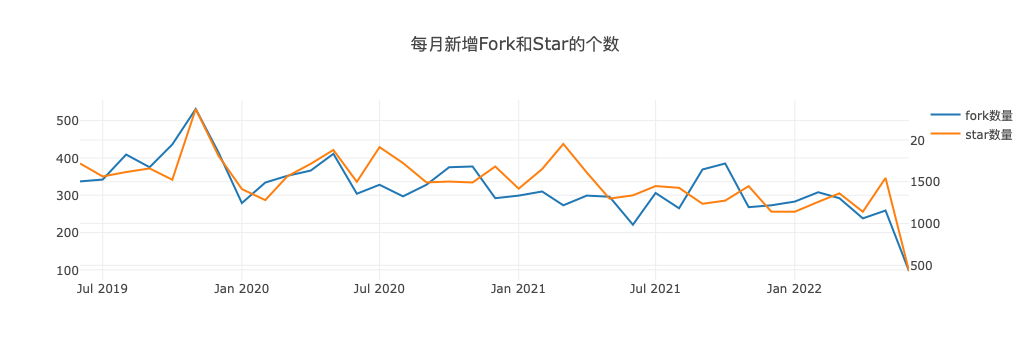

In [152]:
var years = [2015,2016,2017,2018,2019,2020,2021,2022]
Promise.all(
  years.map((year) => {
    return   query( `SELECT  formatDateTime(created_at, '%Y-%m') as date, max(repo_stargazers_count) as star ,max(repo_forks_count) as fork
FROM github_log.events  
where repo_name='microsoft/vscode' and repo_stargazers_count >0 and repo_forks_count>0
    group by formatDateTime(created_at, '%Y-%m')
    order by formatDateTime(created_at, '%Y-%m')
`);
  })
).then(res=>{   
    // console.log(res[0])
    star=[]
    fork=[]
    month=[]
    // month.push(res[0][0].date)
    for (var i=1;i<res[0].length;i++){
        star.push(res[0][i].star-res[0][i-1].star)
        fork.push(res[0][i].fork-res[0][i-1].fork)
        month.push(res[0][i].date)
    }
 
  
    
    
            openDigger.render.plotly([
                            {x: month, y: fork, mode: 'scatter', name: 'fork数量'},
                            {x: month, y: star, mode: 'scatter', name: 'star数量', yaxis: 'y2'},
                           ], { title: "每月新增Fork和Star的个数" , 
                                yaxis2: { overlaying: 'y', side: 'right', anchor: 'x' },
                              });
            });

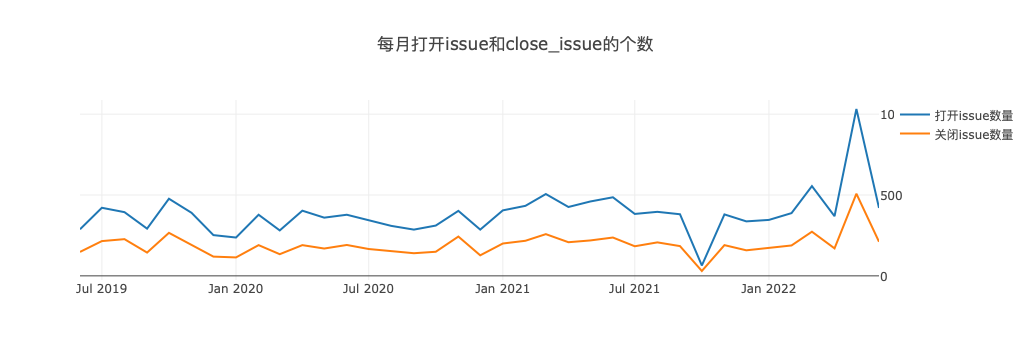

In [153]:
//2查询 打开issue和关闭issue数量
       
            month=[]
            month2=[]
            issues=[]
            cissues=[]

Promise.all(
  years.map((year) => {
    return   query( `SELECT  formatDateTime(created_at, '%Y-%m') as date, count(*)issue_id 
 FROM github_log.events  
where repo_name='microsoft/vscode'and type = 'PullRequestEvent'
    group by formatDateTime(created_at, '%Y-%m')
    order by formatDateTime(created_at, '%Y-%m')
`);
  })
).then(res=>{   
        for (var i=1;i<res[0].length;i++){
         issues.push(res[0][i].issue_id )
        month.push(res[0][i].date)
    }
 

            });

Promise.all(
  years.map((year) => {
    return   query( `SELECT  formatDateTime(created_at, '%Y-%m') as date, count(*)issue_id 
 FROM github_log.events  
where repo_name='microsoft/vscode'and type = 'PullRequestEvent'and issue_created_at<issue_closed_at
 group by formatDateTime(created_at, '%Y-%m')
    order by formatDateTime(created_at, '%Y-%m')
`);
  })
).then(res=>{
   
       for (var i=1;i<res[0].length;i++){
         cissues.push(res[0][i].issue_id )
        month2.push(res[0][i].date)

       }
            openDigger.render.plotly([
                            {x: month, y:  issues, mode: 'scatter', name: '打开issue数量', yaxis: 'y2'},
                            {x: month2, y:  cissues, mode: 'scatter', name: '关闭issue数量', yaxis: 'y2'},
                           ], { title: "每月打开issue和close_issue的个数"  , 
                                yaxis2: { overlaying: 'y', side: 'right', anchor: 'x' },
                              });
            });

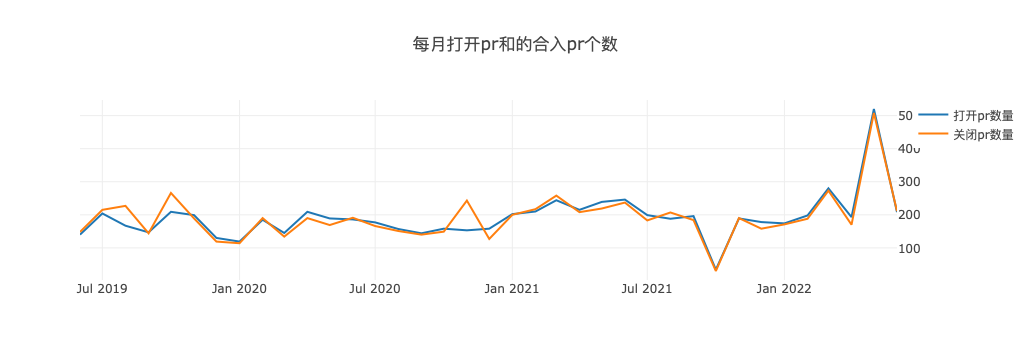

In [157]:
//3每月打开 PR 和合入 PR 的个数
            month=[]
            month2=[]
            open=[]
            close=[]

Promise.all(
  years.map((year) => {
    return    query( `SELECT  formatDateTime(created_at, '%Y-%m') as date, count(*)open
 FROM github_log.events  
where repo_name='microsoft/vscode'and type = 'PullRequestEvent' and action = 'opened'
   group by formatDateTime(created_at, '%Y-%m')
    order by formatDateTime(created_at, '%Y-%m')
 
`);
  })
).then(res=>{   
              for (var i=1;i<res[0].length;i++){
         open.push(res[0][i].open )
        month.push(res[0][i].date)

       }
            });

Promise.all(
  years.map((year) => {
    return   query( `SELECT  formatDateTime(created_at, '%Y-%m') as date, count(*)pull_merged_at
 FROM github_log.events  
where repo_name='microsoft/vscode'and type = 'PullRequestEvent' and action ='closed'
    group by formatDateTime(created_at, '%Y-%m')
    order by formatDateTime(created_at, '%Y-%m')
`);
  })
).then(res=>{   
             for (var i=1;i<res[0].length;i++){
         close.push(res[0][i].pull_merged_at )
        month2.push(res[0][i].date)

       }
        
            openDigger.render.plotly([
                            {x: month, y:  open, mode: 'scatter', name: '打开pr数量', yaxis: 'y2'},
                            {x: month2, y:  close, mode: 'scatter', name: '关闭pr数量', yaxis: 'y2'},
                           ], { title: "每月打开pr和的合入pr个数"  , 
                                yaxis2: { overlaying: 'y', side: 'right', anchor: 'x' },
                              });
            });


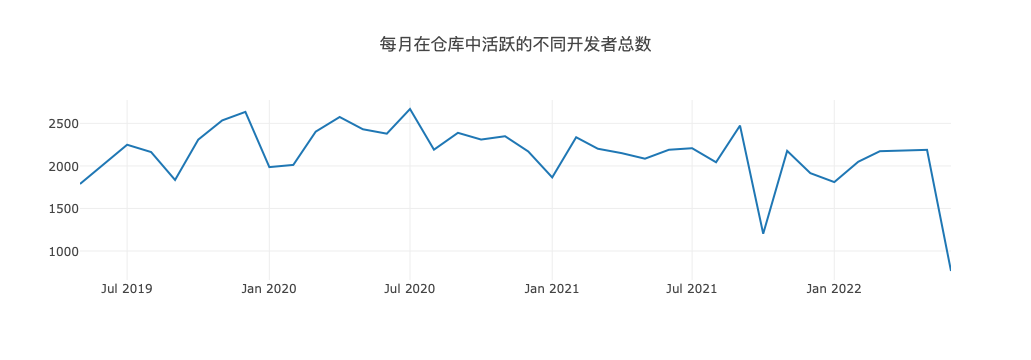

In [156]:
//4

query(
`
    select formatDateTime(created_at, '%Y-%m') as m, count(distinct actor_id) as cnt
    from github_log.events 
    where repo_name = 'microsoft/vscode' 
    and type in ['IssueCommentEvent', 'IssuesEvent', 'PullRequestEvent', 'PullRequestReviewCommentEvent']
    group by formatDateTime(created_at, '%Y-%m')
    order by formatDateTime(created_at, '%Y-%m')
`
).then(
    data => {
        // console.log(data)
        openDigger.render.plotly([
        {y: data.map(d => d.cnt), x: data.map(d => d.m), mode: 'scatter', name: '开发者活跃 数量'},
    ],{title: `每月在仓库中活跃的不同开发者总数`}); 
    }
)

In [37]:
5//Issue 从打开到关闭的平均时长和中位数（单位：天）

  Promise.all(
  years.map((year) => {
    return query( `SELECT toUnixTimestamp(temp.issue_closed_at)-toUnixTimestamp(temp1.issue_created_at) as time
From github_log.events  as temp1,(select issue_created_at,issue_id ,issue_closed_at from github_log.events  where repo_name='microsoft/vscode' and
 type = 'PullRequestEvent' and  action = 'closed') as temp
 where temp1.repo_name='microsoft/vscode' and temp1.type='PullRequestEvent'  and temp.issue_id=temp1.issue_id and temp1.action='opened'
`);
  })
).then(res=>{   
      function sortNumber(a,b){
      return a - b
      }
             times=[]
            let sum=0 
            let len=0
            for(let i= 0;  i < res.length;i++){
                len=len+res[i].length
            for (let j = 0; j < res[i].length; j++) {
                  times[i*res[i].length+j] = Number(res[i][j].time);
                  sum+=Number(res[i][j].time)
                    }
            }
              sum=sum/len
             times.sort(sortNumber)
             console.log(sum/86400+'天平均时间解决issue')
             console.log(times[len/2]/86400+'天中位数时间解决issue')        
          });


13.338223645957047天平均时间解决issue
0.7665856481481481天中位数时间解决issue


In [39]:
6//PR 从打开到合入的平均时长和中位数（单位：天）


Promise.all(
  years.map((year) => {
    return query( `SELECT toUnixTimestamp(temp1.pull_merged_at)-toUnixTimestamp(temp.created_at) as time
From github_log.events  as temp1,(select created_at,issue_id from github_log.events  where repo_name='microsoft/vscode' and
 type = 'PullRequestEvent' and action ='opened') as temp
 where temp1.repo_name='microsoft/vscode' and temp1.type='PullRequestEvent' and temp1.pull_merged=1 and temp.issue_id=temp1.issue_id
`);
  })
).then(res=>{   
      function sortNumber(a,b){
      return a - b
      }
            times=[]
            let sum=0 
            let len=0
            for(let i= 0;  i < res.length;i++){
                len=len+res[i].length
            for (let j = 0; j < res[i].length; j++) {
                  times[i*res[i].length+j] = Number(res[i][j].time);
                  sum+=Number(res[i][j].time)
                    }
            }
              sum=sum/len
             times.sort(sortNumber)
             console.log(sum/86400+'天平均时间pr')
             console.log(times[(len)/2]/86400+'天中位数时间pr')        
          });



7.370732942887969天平均时间pr
0.6565509259259259天中位数时间pr


In [40]:
//7 issue和PR从打开到第一次有人回复(非本人)的平均时长和中位数（单位：天）


Promise.all(
  years.map((year) => {
    return query( `SELECT toUnixTimestamp(issue_comment_created_at)-toUnixTimestamp(issue_created_at) as time
From github_log.events  
 where repo_name='microsoft/vscode' and type='IssueCommentEvent'  and issue_author_id<>
 issue_comment_author_id
`);
  })
).then(res=>{   
      function sortNumber(a,b){
      return a - b
      }
            times=[]
            let sum=0 
            let len=0
            for(let i= 0;  i < res.length;i++){
                len=len+res[i].length
            for (let j = 0; j < res[i].length; j++) {
                  times[i*res[i].length+j] = Number(res[i][j].time);
                  sum+=Number(res[i][j].time)
                    }
            }
              sum=sum/len
             times.sort(sortNumber)
             console.log('第一次有人回复(非本人)的平均时长'+sum/86400+'天')
             console.log('第一次有人回复(非本人)的中位数'+times[len/2+1]/86400+'天')        
          });

第一次有人回复(非本人)的平均时长135.0825240178187天
第一次有人回复(非本人)的中位数3.5388657407407407天
